# PipeTorch Train module

The train module is build around a general purpose Trainer for PyTorch, to quickly train, tune and validate PyTorch models. Much of the training is readily available in PyTorch, we have mostly made it a bit easier to use. Because of the modular design, you can use this trainer with any PyTorch DataLoader and model.

We we cover training in the following topics:
- [Quick example](#Quick-example)
- [Trainer](#Trainer): how to instantiate and configure the trainer
- [train()](#train()): how to train a model
- [Commit](#Commit): how to commit and checkout to models
- [Model management](#Model-management): how to load and save models
- [lr_find()](#lr_find()): to tune the learning rate
- [Hyperparameter tuning](#Hyperparameter-tuning): to assist in tuning multiple hyperparameters using random search

# Quick example

In this example, we will train a model to predict mpg for the autompg dataset. Look at [Trainer configuration](#Trainer) and [train](#train()) for more on the possibilities of training. 

In [1]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 3


In [2]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [3]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [4]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

In [5]:
t.train(100, (3e-4), silent=True)

You can visually diagnose training through `t.learning_curve()`, `t.validation_curve(y=metric)` or a combined plot of loss and all logged metrics through `t.curves()`

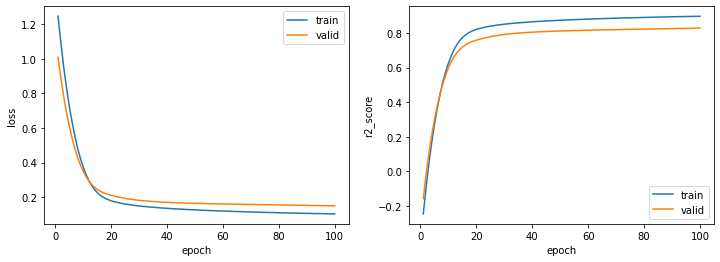

In [6]:
t.curves()

# Trainer

A general purpose trainer for PyTorch.
```
Args:
    model: nn.Module
        a PyTorch Module that will be trained

    loss: callable
        a PyTorch or custom loss function. Note that the loss functions in PyTorch have to be initialized, e.g. nn.BCELoss() and not nn.BCELoss

    *data: databunch or a list of iterables like DataLoaders
        this will take either an object that has a .train_dl, .valid_dl, and optionally .test_dl property,
        like  PipeTorch Databunch (but it does not have to be a Databunch). Alternatively, you can 
        pass a list of at least two iterables (train and valid) like PyTorch DataLoaders. 

    metrics: callable or [ callable ] ([])
        One or more functions that can be called with (y_true, y_pred) to compute an evaluation metric. 
        These metric function will be used during training, for both the train and valid sets at the 
        end of each cycle and logged for validation. Typically, the callable is a function from 
        SKLearn.metrics like mean_squared_error or recall_score. The loss is always logged.

    optimizer: PyTorch Optimizer (AdamW)
        A PyTorch or custom optimizer class that is used during training to update the model parameters.
        You should pass the class and not an optimizer instance. By default, the AdamW optimizer is assumed
        and better supported than other optimizers are.

    optimizer_params: dict (None)
        The parameters that are passed (along with the model parameters) to initialize an optimizer. 
        When a None value is set, the key is removed, so that the default value is used instead.

    scheduler: func or class (None)
        A function or class that returns an intialized scheduler that will be used to change 
        the learning rate and optimizer behavior. Omitting this will allow you to use the lr parameter
        on the train() function to invoke a constant, decaying and cyclic scheduler, that will probably
        suit most needs. Alternatively, if you set this, the function that is called has to accept
        (optimizer, lr, **scheduler_params) as parameters.

    scheduler_params: dict (None)
        additional parameters that are passed when initializing the scheduler

    weight_decay: float (None)
        Apply weight_decay regularization with the AdamW optimizer

    momentum: float (None)
        Apply momentum with the AdamW optimizer

    random_state: int (None)
        used to set a random state for reproducible results

    gpu: bool, int or torch.device (False)
        The device to train on:
            False or -1: cpu
            True: cuda:0, this is probably what you want to train on gpu
            int: cuda:gpu
        Setting the device will automatically move the model and data to the given device. Note that 
        the model is not automatically transfered back to cpu afterwards.

    evaluator: PipeTorch evaluator (None)
        An evaluator that was created by a different trainer or DataFrame, to combine the results of 
        different training sessions.

    debug: bool (False)
        Stores X, y and y_pred in properties so that they can be inspected when an error is thrown.
        You can use t.debug() to reveal the last values for X, y, model(X) and post_forward(model(X)).
```

The quick example shows how this can be used with a Databunch. In this alternative, we pass separate dataloaders to the Trainer, turn gpu=True to train the model on the gpu, and lower the default weight_decay (regularization).

In [7]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [8]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
train_dl = df.train.to_dataloader(batch_size=32)
valid_dl = df.valid.to_dataloader(batch_size=len(df.valid))

In [34]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [35]:
t = Trainer(model, nn.MSELoss(), train_dl, valid_dl, metrics=r2_score, gpu=True, weight_decay=1e-4)

In [37]:
t.train(100, 1e-4, silent=True, log={'custom':'my value'})

### results

The values for the loss function and metrics will be stored atthe end of every cycle in a PipeTorch Evaluator, that uses a DataFrame to log all results. If you want to access these for an alternative way to diagnose training, you can access the raw data through `r.evaluator.results`. You can use the `log` parameter on [train()](train()) to record additional information.

In [38]:
t.evaluator

       custom  epoch    metric  phase     value
0    my value    1.0  r2_score  train -0.151563
1    my value    1.0      loss  train  1.151563
2    my value    1.0  r2_score  valid -0.187579
3    my value    1.0      loss  valid  0.802477
4    my value    2.0  r2_score  train -0.108562
..        ...    ...       ...    ...       ...
395  my value   99.0      loss  valid  0.121905
396  my value  100.0  r2_score  train  0.809705
397  my value  100.0      loss  train  0.190295
398  my value  100.0  r2_score  valid  0.820075
399  my value  100.0      loss  valid  0.121580

[400 rows x 5 columns]

# train()

Train the model for the given number of epochs or until a targetloss or earlystop criterium is reached. Loss and metrics are logged at the end of each cycle during training in an evaluator. If a model was already (partially) trained, training will continue where it was left off.
```
Args:
    epochs: int
        the number of epochs to train the model

    lr: float, (float, float), or [float, float] (None)
        float: use a fixed learning rate
        (upper, lower): switch the scheduler to OneCycleLR and use a cyclic annealing learning rate
            between an upper and lower bound.
        [upper, lower]: switch the scheduler to Linear Decay and use a linearly decaying learning rate
            between an upper and lower bound.
        None: use the last learning rate or the default in AdamW

    cycle: int (None)
        Configures after how many epochs there are in a cycle the loss and metrics are logged and 
        reported at the end of every cycle. This is remembered for consecutive calls to train.

    silent: bool (False)
        Whether to report progress. Note that even when silent=True
        the metrics are still logged at the end of every cycle.

    log: dict ({})
        these values are logged along with the loss and metric scores at the end of each cycle. This makes it
        easier to combine several runs into one evaluator, and create an overview (plot) to compare them.

    save: str (None)
        If not None, saves (commits) the model at the end of each cycle
        under the name 'save'-epochnr

    optimizer: PyTorch Optimizer (None)
        If not None, changes the optimizer class to use.

    optimizer_params: dict (None)
        If not None, changes the parameters to configure the optimizer.

    scheduler: None, custom scheduler class
        used to adapt the learning rate. Set OneCycleLR or Linear Decay through the learning rate. 
        Otherwise, provide a custom class/function to initialize a scheduler by accepting
        (optimizer, learning_rate, scheduler_cycle)

    scheduler_params: dict (None)
        additional parameters that are passed when initializing the scheduler

    weight_decay: float
        Apply weight_decay regularization with the AdamW optimizer

    momentum: float
        Apply momentum with the AdamW optimizer

    targetloss: float (None)
        terminates training when the validation loss drops below the targetloss.

    earlystop: int (False)
        terminates training when the validation loss has not improved for the last
        earlystop cycles.

    save_lowest: bool (False)
        when the validation loss is lower than seen before, the model is saved/committed as 'lowest' 
        and can be checked out by calling lowest() on the trainer.

    test: bool (False)
        run the test set every cycle (used for n-fold cross validation)
```

In [17]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [18]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [19]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [20]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

Without `silent=True`, the train() method will report losses and metrics over the validation set at the end of every cycle. It will also use a progress bar to give you an indication how long training will take.

In [21]:
t.train(20, 1e-4, cycle=10)

Total:   0%|          | 0/32800 [00:00<?, ?it/s]

 10 0.12s trainloss=0.75410 validloss=0.83395 r2_score=0.25708 
 20 0.11s trainloss=0.46932 validloss=0.53495 r2_score=0.52344 
 30 0.11s trainloss=0.31561 validloss=0.35630 r2_score=0.68260 
 40 0.11s trainloss=0.24100 validloss=0.25902 r2_score=0.76925 
 50 0.11s trainloss=0.20737 validloss=0.20763 r2_score=0.81503 
 60 0.11s trainloss=0.18972 validloss=0.17983 r2_score=0.83980 
 70 0.11s trainloss=0.17832 validloss=0.16254 r2_score=0.85520 
 80 0.11s trainloss=0.16966 validloss=0.15084 r2_score=0.86562 
 90 0.11s trainloss=0.16261 validloss=0.14193 r2_score=0.87357 
100 0.11s trainloss=0.15675 validloss=0.13492 r2_score=0.87980 


A subsequent call to train will continue where you have left off, allowing to change the learning hyperparameters.

In [21]:
t.train(20, 1e-4, cycle=10)

Total:   0%|          | 0/32800 [00:00<?, ?it/s]

 10 0.12s trainloss=0.75410 validloss=0.83395 r2_score=0.25708 
 20 0.11s trainloss=0.46932 validloss=0.53495 r2_score=0.52344 
 30 0.11s trainloss=0.31561 validloss=0.35630 r2_score=0.68260 
 40 0.11s trainloss=0.24100 validloss=0.25902 r2_score=0.76925 
 50 0.11s trainloss=0.20737 validloss=0.20763 r2_score=0.81503 
 60 0.11s trainloss=0.18972 validloss=0.17983 r2_score=0.83980 
 70 0.11s trainloss=0.17832 validloss=0.16254 r2_score=0.85520 
 80 0.11s trainloss=0.16966 validloss=0.15084 r2_score=0.86562 
 90 0.11s trainloss=0.16261 validloss=0.14193 r2_score=0.87357 
100 0.11s trainloss=0.15675 validloss=0.13492 r2_score=0.87980 


# Commit

The Trainer provides a mechanism to commit, checkout and revert to different versions of the model. For example, for multi-stage learning a model that may overfit, the process can be automated by training in the first stage, reverting back to the model with the lowest validation loss, and then proceeding with the next stage. There are several options:
- t.train(..., save_lowest=True): commits a model if the validation loss is lowest than ever seen. You can retrieve the 'best' model using `t.lowest()`
- t.train(..., save='mymodel'): commits versions of the model after every cycle under the name 'mymodel-{epoch}'

When working with committed models, you can use the following functions to work with them:
- t.commit(label): commits the current model under this label
- t.list_commits(): lists the names of all committed models
- t.revert(label): returns the model to that committed state and removes the commit point
- t.checkout(label): returns the model to that committed state and keeps the commit point
- t.purge(label): returns the model to that committed state and removes all other commit points

In [27]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [28]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [29]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [30]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

We will use a learning rate that is to high so that it is likely that the learning curve will oscillate.

In [31]:
t.train(100, 1e-2, cycle=10, save_lowest=True)

Total:   0%|          | 0/32800 [00:00<?, ?it/s]

 10 0.13s trainloss=0.10180 validloss=0.13363 r2_score=0.84765 
 20 0.11s trainloss=0.09145 validloss=0.13107 r2_score=0.85057 
 30 0.11s trainloss=0.07667 validloss=0.12739 r2_score=0.85477 
 40 0.11s trainloss=0.07047 validloss=0.14073 r2_score=0.83956 
 50 0.12s trainloss=0.06782 validloss=0.14495 r2_score=0.83475 
 60 0.11s trainloss=0.06236 validloss=0.13502 r2_score=0.84607 
 70 0.11s trainloss=0.06644 validloss=0.14442 r2_score=0.83535 
 80 0.11s trainloss=0.06451 validloss=0.15433 r2_score=0.82405 
 90 0.11s trainloss=0.05354 validloss=0.14231 r2_score=0.83775 
100 0.11s trainloss=0.06567 validloss=0.17476 r2_score=0.80077 


Checkout to the lowest version and look at the valdation loss.

In [32]:
t.lowest()

In [33]:
t.validate_loss()

0.12738972902297974

# Model management

The Trainer has built-in function to load, save and reset the model:
- `t.save(folder, filename, extension)`: saves the current model. By default, currentfolder/classname.pyt-{PyTorch version} will be used.
- `t.load(folder, filename, extension)`: loads the saved model.
- `t.reset_model()`: reinitializes all weights to random.
- `t.to(device)`: changes the configuration to a different device, which will take effect when calling `t.model` or any function that uses the model (like `train()`)
  - `False`: cpu
  - `True`: cuda:0
  - `int`: cuda:{device}

# lr_find()

This method helps optimizing the learning rate finder of the current model on the current dataset (as proposed by Leslie Smith and implemented in FastAI). This function commits the model, then iteratively trains over mini-batches while slowly increasing the learning rate.

The result is a plot of the validation loss over the learning rate. The idea is that the graph contains information on a stable setting of the learning rate and it is recommended to set the learning rate at the lowest learning rate that accelerates improvement of the loss. This does not always work, and often after some training, if learning is not stable, the learning rate still needs to be adjusted. 
```
Args:
    lr: [small float, big float] ([1e-6, 10])
        Interval of learning rates to inspect
        
    steps: int (40)
        number of (exponential) steps to divide the learning rate interval in
        
    smooth: float (0.05)
        smoothing parameter, to generate a more readable graph
        
    cache_valid: bool (True)
        whether to keep the validation set if possible in memory. Switch off if there is insufficient memory
```

In [27]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [28]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [29]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [30]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

So on this example, a learning rate of 1e-2 is clearly too high, but a setting of 3e-3 may already be too close to the 'danger zone' so that the model does not fully converge. Therefore a setting of 1e-3 may be optimal, since this is where the loss accelerates.

  0%|          | 0/40 [00:00<?, ?it/s]

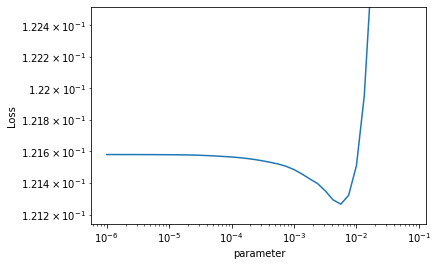

In [39]:
t.lr_find([1e-6, 1e-1], 40)

# Hyperparameter tuning

Hyperparameters are usually not learned directly from training, but by trying out different settings, fully training a model each time and comparing the results. PipeTorch embeds the Optuna library to assist in tuning. You will need to provide a function that performs a 'trail' in which a model is optimally trained and the results are returned. Within this trial function, you will use the Optuna.Trial object that is passed to sample your hyperparameters from a random distribution. 

In [1]:
from pipetorch.data import read_from_kaggle
from pipetorch.model import MultiLayerPerceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 3


In [2]:
df = read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [3]:
model = MultiLayerPerceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [4]:
t = Trainer(None, nn.MSELoss(), db, metrics=r2_score)

In [5]:
def trial(trial):
    hidden = trial.suggest_int('hidden', 1, 100)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    t.model = MultiLayerPerceptron(6, hidden, 1)
    t.train(200, lr=lr, weight_decay=0.01, earlystop=10, silent=True)
    return t.optimum()

In [8]:
study = t.optimize(trial, n_trials=20)

[I 2022-05-20 13:50:44,555] A new study created in memory with name: no-name-9a4265c5-236d-487c-921d-d7d139395404
[I 2022-05-20 13:50:48,533] Trial 0 finished with values: [0.1612110435962677, 0.8275476491249673] and parameters: {'hidden': 53, 'lr': 5.410505336551586e-05}. 
[I 2022-05-20 13:50:52,492] Trial 1 finished with values: [0.10742572695016861, 0.8850834549841478] and parameters: {'hidden': 64, 'lr': 0.03457458938723495}. 
[I 2022-05-20 13:50:56,460] Trial 2 finished with values: [0.20831303298473358, 0.7771612541187393] and parameters: {'hidden': 84, 'lr': 4.0113085377124966e-05}. 
[I 2022-05-20 13:51:00,408] Trial 3 finished with values: [0.18193528056144714, 0.8053783098243776] and parameters: {'hidden': 61, 'lr': 3.35164097433887e-05}. 
[I 2022-05-20 13:51:04,376] Trial 4 finished with values: [0.0984058827161789, 0.8947322567465477] and parameters: {'hidden': 96, 'lr': 0.031859090559517654}. 
[I 2022-05-20 13:51:08,307] Trial 5 finished with values: [0.0961398035287857, 0.

The resulting plot can be a bit of a puzzle to figure out. Just looking at the loss, the high values indicate bad results. If for a certain hyperparameter a whole region (usually on the left or right hand side of the plot) has bad results, that is an indication the underperformance could have been caused by setting the hyperparameter in that region. However, if another hyperparameter is already causing a bad result, you should disregard that in the analysis of the other hyperparameters. In the future, we may provide a more clever mechanism for this analysis.

In this example, you should see that learning rates below $10e-4$ are underperforming, but also that learning rates close to $1e-1$ become too big. In the analysis of the hidden layer size, you should ignore the trails that are underperforming due to a wrong learning rate. Then it appears there is a trend that higher hidden size values perform better. We should rerun with even higher values to find the optimum.

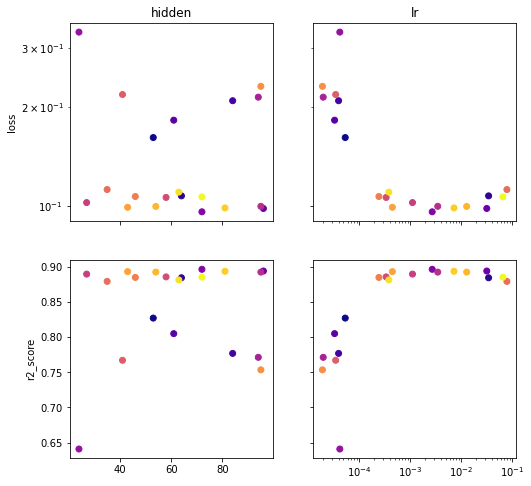

In [9]:
study.plot_hyperparameters()

You can also view the flat results in a DataFrame.

In [10]:
study.results()

,trial,parameter,parametersetting,target,targetvalue
0,0,hidden,13.000000,loss,0.145850
1,0,hidden,13.000000,r2_score,0.839916
2,0,lr,0.001018,loss,0.145850
3,0,lr,0.001018,r2_score,0.839916
4,1,hidden,1.000000,loss,0.170760
5,1,hidden,1.000000,r2_score,0.812575
6,1,lr,0.075344,loss,0.170760
7,1,lr,0.075344,r2_score,0.812575
8,2,hidden,76.000000,loss,0.599156
9,2,hidden,76.000000,r2_score,0.342371
